In [1]:
import pandas as pd
import pickle

In [2]:
def save_obj(obj, fname):
    directory = '../../data/processed/dev/'
    # This writes out a python object as a pickle.
    with open(directory + fname + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(fname):
    directory = '../../data/processed/dev/'
    # This writes out a python object as a pickle.
    with open(directory + fname + '.pkl', 'rb') as f:
        return pickle.load(f)

### Load Data

In [3]:
train_path = '../../data/raw/train.csv'
val_path = '../../data/raw/dev.csv'

In [4]:
train = pd.read_csv(train_path)
validation = pd.read_csv(val_path)

In [5]:
train.head(5)

,ex_id,user_id,prod_id,rating,label,date,review
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...
1,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...
2,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...
3,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...
4,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...


#### Summary Statistics

In [54]:
import numpy as np

In [6]:
train['date'].min(), train['date'].max()

('2004-10-20', '2015-01-07')

In [7]:
train.describe()

,ex_id,user_id,prod_id,rating,label
count,250874.000000,250874.000000,250874.000000,250874.000000,250874.000000
mean,179413.488815,53970.730446,459.778211,4.023717,0.102916
std,103640.791253,45803.665418,259.854178,1.056995,0.303850
min,0.000000,923.000000,0.000000,1.000000,0.000000
25%,89526.500000,13820.000000,247.000000,4.000000,0.000000
50%,179345.500000,40485.500000,468.000000,4.000000,0.000000
75%,269196.750000,87298.000000,672.000000,5.000000,0.000000
max,358956.000000,161147.000000,922.000000,5.000000,1.000000


In [30]:
train.groupby(['label']).count()

,ex_id,user_id,prod_id,rating,date,review,tokens,filtered_tokens
label,,,,,,,,
0,225055,225055,225055,225055,225055,225055,225055,225055
1,25819,25819,25819,25819,25819,25819,25819,25819


### Tokenizing Text

In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

In [9]:
stop_words = set(stopwords.words('english')) 

In [10]:
train['tokens'] = train['review'].apply(lambda x: word_tokenize(x) )

In [51]:
stop_words = set(stopwords.words('english')) 

def rm_stop_words(tokens):
    filtered = [w for w in tokens if not w.lower() in stop_words] 
    return filtered

def rm_puctuation(tokens):
    init_filter = [w for w in tokens if w not in string.punctuation]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in init_filter]
    clean = [w for w in stripped if w not in ['',' ']]
    return clean

def filter_tokens(tokens):
    filtered = rm_stop_words(tokens)
    new_tokens = rm_puctuation(filtered)
    return new_tokens

In [52]:
train['filtered_tokens'] = train['tokens'].apply(lambda x: filter_tokens(x))

In [13]:
train.head(5)

,ex_id,user_id,prod_id,rating,label,date,review,tokens,filtered_tokens
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...,"[The, food, at, snack, is, a, selection, of, p...","[food, snack, selection, popular, Greek, dishe..."
1,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...,"[This, little, place, in, Soho, is, wonderful,...","[little, place, Soho, wonderful, lamb, sandwic..."
2,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,"[ordered, lunch, for, 15, from, Snack, last, F...","[ordered, lunch, 15, Snack, last, Friday, time..."
3,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...,"[This, is, a, beautiful, quaint, little, resta...","[beautiful, quaint, little, restaurant, pretty..."
4,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...,"[Snack, is, great, place, for, a, casual, sit,...","[Snack, great, place, casual, sit, lunch, espe..."


In [49]:
train[train['label'] == 1]['review'].head(5)

0    The food at snack is a selection of popular Gr...
1    This little place in Soho is wonderful. I had ...
2    ordered lunch for 15 from Snack last Friday.  ...
3    This is a beautiful quaint little restaurant o...
4    Snack is great place for a  casual sit down lu...
Name: review, dtype: object

In [48]:
train[train['label'] == 0]['review']

11        I had the braised lamb sandwich and was one of...
12        This spot is close to my job so I decided to c...
13        Needed a quick, healthy light "lunch" and this...
14        Their artichoke chicken salad is good and plenty.
15        Needed a quick bite and stopped here because o...
                                ...                        
250869    Made a reservation for an early dinner Saturda...
250870    Emily is like Franny's Marco, but with warmth ...
250871    Can't say enough good things about this place....
250872    Had a great dinner here- fantastic pizza, the ...
250873    Pizza Loves Emily and I love Emily's pizza. Th...
Name: review, Length: 225055, dtype: object

### Find Word Frequency

In [14]:
from collections import Counter
import operator

In [31]:
flat_list = [item.lower() for sublist in train['filtered_tokens'].values for item in sublist]
flat_list_fake = [item.lower() for sublist in train[train['label']==1]['filtered_tokens'].values for item in sublist]
flat_list_real = [item.lower() for sublist in train[train['label']==0]['filtered_tokens'].values for item in sublist]

In [33]:
word_freq = Counter(flat_list)
word_freq_fake = Counter(flat_list_fake)
word_freq_real = Counter(flat_list_real)

# west village is one word
# remove words that appear once?
# frequent word pairs? 'great place' 'good food'

# https://en.wikipedia.org/wiki/List_of_Manhattan_neighborhoods
# https://en.wikipedia.org/wiki/List_of_Brooklyn_neighborhoods

In [34]:
# save_obj(word_freq , 'word_freq_ac4119')
# save_obj(word_freq_real , 'word_freq_real_ac4119')
# save_obj(word_freq_fake , 'word_freq_fake_ac4119')

In [18]:
word_freq = load_obj('word_freq_ac4119')

In [35]:
sorted_freq = sorted(word_freq.items(), key=operator.itemgetter(1))
sorted_freq_fake = sorted(word_freq_fake.items(), key=operator.itemgetter(1))
sorted_freq_real = sorted(word_freq_real.items(), key=operator.itemgetter(1))

In [ ]:
huihkn

### Visualize

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

/Users/chuamelia/anaconda/envs/py35/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [21]:
total_words = len(word_freq)
print("{:,} unique words".format(total_words))

162,132 unique words


In [23]:
f_rank = pd.DataFrame\
.from_records(sorted_freq[:-3], columns=['word','freq'])\
.sort_values(by='freq', ascending=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

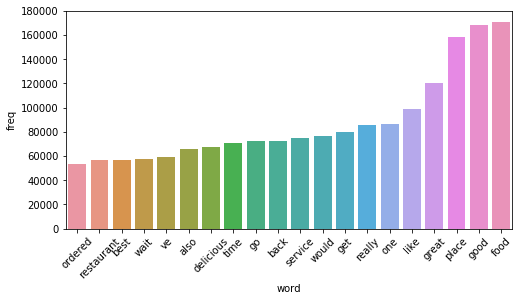

In [26]:
# Top 20 overall
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.barplot(x='word', y='freq', data=f_rank[-20:])
plt.xticks(rotation=45)

In [40]:
f_rank_fake = pd.DataFrame\
.from_records(sorted_freq_fake[-23:], columns=['word','freq'])\
.sort_values(by='freq', ascending=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text xticklabel objects>)

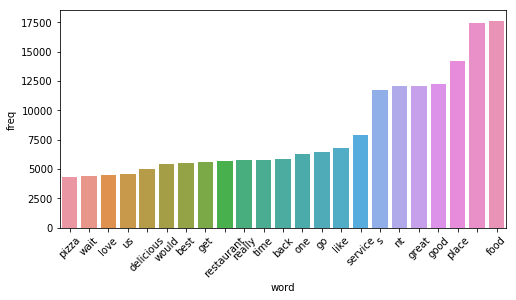

In [42]:
# Top 20 Fake
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.barplot(x='word', y='freq', data=f_rank_fake)
plt.xticks(rotation=45)

In [41]:
f_rank_real = pd.DataFrame\
.from_records(sorted_freq_real[-23:-3], columns=['word','freq'])\
.sort_values(by='freq', ascending=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

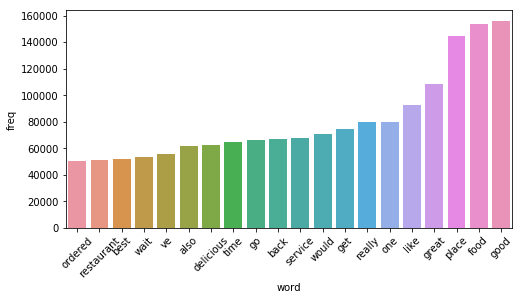

In [43]:
# Top 20 Real
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.barplot(x='word', y='freq', data=f_rank_real)
plt.xticks(rotation=45)

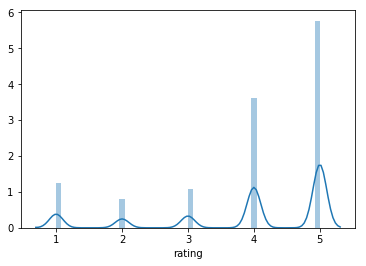

In [58]:
sns.distplot(train[train['label']==1]['rating'])


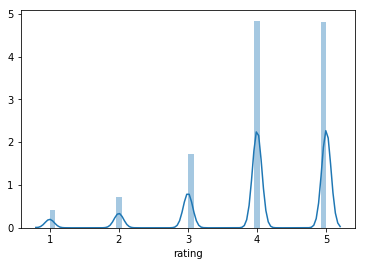

In [59]:
sns.distplot(train[train['label']==0]['rating'])

In [65]:
pd.set_option('display.max_colwidth', -1)
train[(train['label']==1) & (train['rating']==1)][['review', 'rating']]

/Users/chuamelia/anaconda/envs/py35/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,review,rating
155,"My wife and I took my parents there for lunch and were greeted by stares from the staff with no greeting whatsoever despite there being only five people in the entire place. This was followed by a rude, abrupt waitress who acted like we had to speed talk to place an order. To cap off this wonderful experience, the pizza was non descript and the pasta tasted like it had been ordered from a diner. So poor, in fact, that my two kids, who normally love pasta, refused to eat theirs. Won't be back and will definitely not recommend this place to anyone.",1.0
156,Got a margarita pizza. First off let me say very expensive that one pie came out to 25$ with 2 simple toppings on it. Secondly the was a piece of hair in it. Also the sauce was bland. My table was all oily. Definitely not recommending this place might as well go down the block to Tommys. Again HORRIBLE.,1.0
759,lady that works there picks her nose. - yuck!,1.0
818,"I used to love this place when it was Xunta-a very authentic Spanish tapas bar, casual, informal bar with tapas and a great atmosphere - so I went for years, bringing many out of town visitors and friends for happy hour and on weekends. Now, sadly, I have to say that Nai is not the same place and not worth spending your money there. The new owner has made a lot of changes, for the worse, imo, and is very strange (looks like some dude from Queens)-he seems to be always there,with a scowl on his face, is neither inviting nor welcoming, and acts dismissive and like he is doing you a favor even talking to you-when we even show up early for reservations and have done nothing except wanting to patronize his bar! He runs the place like a formal dining restaurant..it feels like you have to be in exactly on time, spend your pricepoint, and get out-all very anti-tapas bar to me. At my birthday celebration of 10 people, he actually did ask us to leave after 2 hours because he ""needed"" the table though we had spent several hundred dollars and were still eating and drinking! I was flabbergasted at how rude that was. Also I noticed that since the change to Nai, the food is not as good as it used to be (octopus and other dishes not cooked well), with higher prices as well, and the sangria is now also watered down/sweet imo--just not a good value. And the décor now is blah (think tacky flamenco paintings from homedecorators.com)-does not have any of the charm or personality of the old Xunta. Sadly, after giving it a go a couple of times, I am in search once again of an authentic Spanish tapas bar.",1.0
1164,"I have to say I didn't actually eat here so the food could be good, but when I called to ask for a reservation they said to call back later and hung up on me. There are many other choices where I can be treated better than that.",1.0
...,...,...
250332,"Visiting New York for several days, and this was by far the worst restaurant I ate at. The food was okay, but the service was horrendous. The waiter was rude and didn't seem to care for people's food allergies. First, he put a fork that was dropped on to the floor back on to a table for the next unknowing customer to use. After claiming that the meal is nut-free multiple times, my friend develops anaphylaxis after having the appetizer. The manager or the waiter said there were no nuts in the food, but found out almonds were in the appetizer after asking the chef. The manager hovers over us for the rest of the meal. Please save yourself and don't go to this restaurant.",1.0
250333,"We ordered food but it was never delivered to us. We called the restaurant and the manager started yelling at me and stated that the food was delivered. We ordered via Seamless.com so that we paid when we ordered. I have never experienced such a horrible attitude as displayed by this manager. He treated us horribly rude. He was very aggressive, inconsiderate and unacceptably hostile. Bottom line: We paid $25, never received any food and were even yelled at. Please do yourself a f

In [ ]:
# Later: https://observablehq.com/@d3/bubble-chart